## Hierarchical Clustering
(This section of the notebook is largely taken from [dashee87](https://github.com/dashee87))

This notebook will start by covering how Hierarchical works, how to use Hierarchical clustering in Python and some strengths and weaknesses of Hierarchical clustering. 

### What is Hierarchical Clustering

![hierarchicalgif](images/hierarchicalClustering.gif)

Unlike k-means, hierarchical clustering doesn't require the user to specify the number of clusters beforehand. Instead it returns an output, from which the user can decide the appropriate number of clusters (either manually or algorithmically. If done manually, the user may cut the dendrogram (a graph that displays all of these links in their hierarchical structure) where the merged clusters are too far apart (represented by a long lines in the dendrogram). Alternatively, the user can just return a specific number of clusters (similar to k-means)

As its name suggests, it constructs a hierarchy of clusters based on proximity (e.g Euclidean distance or Manhattan distance- see GIF below). HC typically comes in two flavours (essentially, bottom up or top down): 

* Divisive: Starts with the entire dataset comprising one cluster that is iteratively split- one point at a time- until each point forms its own cluster.
* Agglomerative: The agglomerative method in reverse- individual points are iteratively combined until all points belong to the same cluster.

Another important concept in HC is the linkage criterion. This defines the distance between clusters as a function of the points in each cluster and determines which clusters are merged/split at each step. That clumsy sentence is neatly illustrated in the GIF below.

![title](images/euclideanDistance.gif)

Here is roughly how Hierarchical clustering works: 
1. Create a cluster for each point, containing only that point. 
2. Choose the two clusters with centroids closest to each other.
    * Combine the two clusters into a new cluster that replaces the two individual clusters. (Create a new parent node.)
3. Repeat Step 2 until only one cluster remains.

## Comparing Clustering Algorithms

* K-means
  * Centroid based clustering algorithm (K-means seeks to minimize the sum of squares of each point about its cluster centroid).
  * find k clusters (k is user-specified), each distributed around a single point (called a centroid, an imaginary “center point” or the cluster’s “center of mass”)
  - Assumes clusters are isotropic (circular/spherical distribution).
- Hierarchical clustering
  - Builds hierarchies of clusters
  - Hierarchical clustering works well for non-spherical clusters.
  - May be computationally expensive.
  - Guaranteed to converge to the same solution (no random initialization).

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For scaling data
from sklearn.preprocessing import StandardScaler

# Dataset import
from sklearn.datasets import load_iris

# Model imports
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets

from sklearn.preprocessing import StandardScaler

### Create Data
You can ignore how these datasets are created since they are just used for illustrative purposes. 

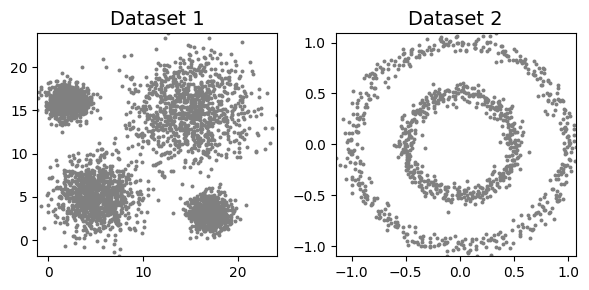

In [3]:
np.random.seed(844)
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)
dataset1 = np.concatenate((clust1, clust2, clust3, clust4))

# we take the first array as the second array has the cluster labels
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

# plot clustering output on the two datasets
def cluster_plots(set1, set2, colours1 = 'gray', colours2 = 'gray', 
                  title1 = 'Dataset 1',  title2 = 'Dataset 2'):
    fig,(ax1,ax2) = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
    ax1.set_title(title1,fontsize=14)
    ax1.set_xlim(min(set1[:,0]), max(set1[:,0]))
    ax1.set_ylim(min(set1[:,1]), max(set1[:,1]))
    ax1.scatter(set1[:, 0], set1[:, 1],s=8,lw=0,c= colours1)
    ax2.set_title(title2,fontsize=14)
    ax2.set_xlim(min(set2[:,0]), max(set2[:,0]))
    ax2.set_ylim(min(set2[:,1]), max(set2[:,1]))
    ax2.scatter(set2[:, 0], set2[:, 1],s=8,lw=0,c=colours2)
    fig.tight_layout()
    plt.show()

cluster_plots(dataset1, dataset2)

Dataset 1
Cluster 0: 990
Cluster 1: 1008
Cluster 2: 1002
Cluster 3: 1000


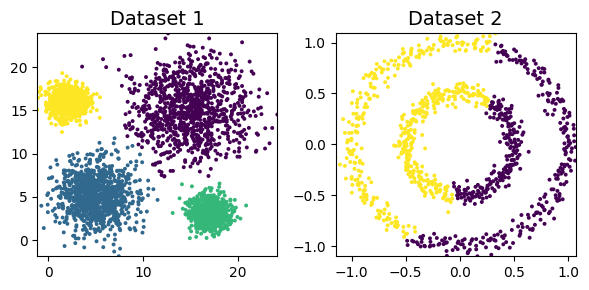

In [5]:
# implementing agglomerative (bottom up) hierarchical clustering
# we're going to specify that we want 4 and 2 clusters, respectively
hc_dataset1 = cluster.AgglomerativeClustering(n_clusters=4, metric='euclidean', 
                                              linkage='ward').fit_predict(dataset1)
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=2, metric='euclidean', 
                                              linkage='average').fit_predict(dataset2)
print("Dataset 1")
print(*["Cluster "+str(i)+": "+ str(sum(hc_dataset1==i)) for i in range(4)], sep='\n')
cluster_plots(dataset1, dataset2, hc_dataset1, hc_dataset2)

You might notice that HC didn't perform so well on the circles. By imposing simple connectivity constraints (points can only cluster with their n(=5) nearest neighbours), HC captures the non-globular structures within the dataset.

/Users/kangfang/anaconda3/envs/deepfilternet/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:593: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


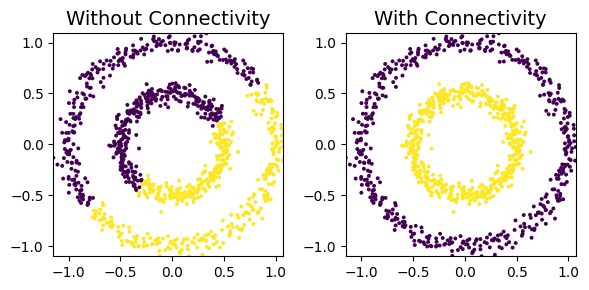

In [6]:
hc_dataset2 = cluster.AgglomerativeClustering(n_clusters=2, metric='euclidean', 
                                              linkage='complete').fit_predict(dataset2)
connect = kneighbors_graph(dataset2, n_neighbors=5, include_self=False)
hc_dataset2_connectivity = cluster.AgglomerativeClustering(n_clusters=2, metric='euclidean', 
                                              linkage='complete',connectivity=connect).fit_predict(dataset2)
cluster_plots(dataset2, dataset2,hc_dataset2,hc_dataset2_connectivity,
             title1='Without Connectivity', title2='With Connectivity')

Conveniently, the position of each observation isn't necessary for HC, but rather the distance between each point (e.g. a n x n matrix). However, the main disadvantage of HC is that it requires too much memory for large datasets (that n x n matrix blows up pretty quickly). Divisive clustering is $O(2^n)$, while agglomerative clustering comes in somewhat better at $O(n^2 log(n))$ (though special cases of $O(n^2)$ are available for single and maximum linkage agglomerative clustering).

## An Example on a Dataset

### Load Data
<b>About the dataset:</b> This is a small dataset that has information on about 50 animals. The animals are listed in classes.txt. For each animal, the information consists of values for 85 features: does the animal have a tail, is it slow, does it have tusks, etc. The details of the features are in the predicates.txt. The full data consists of a 50 x 85 matrix of real values, in predicate-matrix-continuous.txt. There is also a binarized version of this data, in predicate-matrix-binary.txt.

In [11]:
samples_features = pd.read_fwf("data/predicate-matrix-continuous.txt", header=None).values
print(samples_features.shape)
# 50 is the number of samples n (number of animals)
# 85 is the number of features m (number of features)

(50, 85)


In [12]:
samples_features.shape

(50, 85)

In [13]:
classes=pd.read_fwf("data/classes.txt", header=None)[1].values
classes

array(['antelope', 'grizzly+bear', 'killer+whale', 'beaver', 'dalmatian',
       'persian+cat', 'horse', 'german+shepherd', 'blue+whale',
       'siamese+cat', 'skunk', 'mole', 'tiger', 'hippopotamus', 'leopard',
       'moose', 'spider+monkey', 'humpback+whale', 'elephant', 'gorilla',
       'ox', 'fox', 'sheep', 'seal', 'chimpanzee', 'hamster', 'squirrel',
       'rhinoceros', 'rabbit', 'bat', 'giraffe', 'wolf', 'chihuahua',
       'rat', 'weasel', 'otter', 'buffalo', 'zebra', 'giant+panda',
       'deer', 'bobcat', 'pig', 'lion', 'mouse', 'polar+bear', 'collie',
       'walrus', 'raccoon', 'cow', 'dolphin'], dtype=object)

In order to make the real_value array data (samples_features) clearer, I put it into a pandas dataframe. Please notice how all the animals differ from each other. For example, notice how the dalmation has the column spots at 100 and the other dogs have values around 10.

In [14]:
feature_names=pd.read_fwf("data/predicates.txt", header=None)[1].values
classes_features = pd.DataFrame(data = samples_features, columns = feature_names)
classes_features.index = classes
classes_features.loc[['german+shepherd', 'collie', 'dalmatian'], :]

,black,white,blue,brown,gray,orange,red,yellow,patches,spots,...,water,tree,cave,fierce,timid,smart,group,solitary,nestspot,domestic
german+shepherd,43.54,15.88,5.0,54.16,26.82,3.12,2.5,0.38,48.78,11.59,...,3.75,0.00,2.5,57.44,10.00,57.53,12.50,35.11,16.53,68.55
collie,10.13,41.37,0.0,47.27,3.75,8.00,0.5,0.00,37.00,9.09,...,0.00,0.00,0.0,5.25,43.09,42.17,0.62,45.99,18.57,79.11
dalmatian,69.58,73.33,0.0,6.39,0.00,0.00,0.0,0.00,37.08,100.00,...,1.25,6.25,0.0,9.38,31.67,53.26,24.44,29.38,11.25,72.71


In [15]:
scaler = StandardScaler()
samples_features = scaler.fit_transform(samples_features)

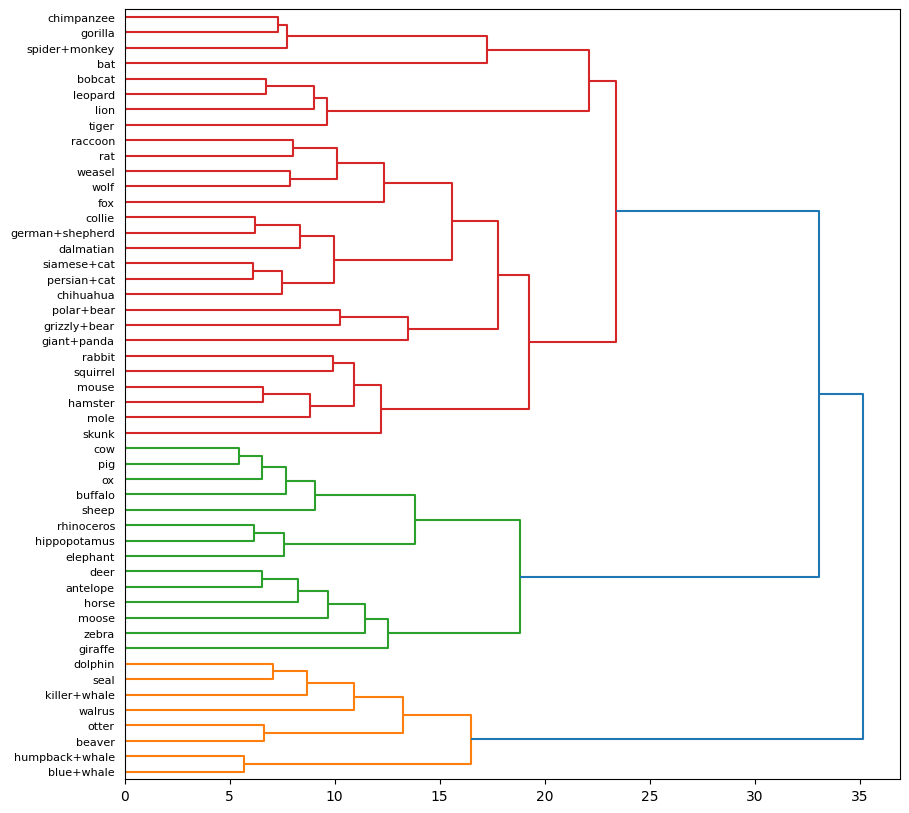

In [16]:
plt.figure(figsize = (10,10));

# cluster_link array (contains the hierarchical clustering information)
cluster_link = linkage(samples_features, method='ward');

dendrogram(cluster_link, orientation="right", labels=classes);
plt.savefig('images/hierarchicalClustering.png', dpi = 300)

The dendrogram seems to make some intuitive sense. The grouping of polar and grizzly bears together plus the other hierarchical relationships makes this an intriguing option </h2>

### YouTube Thumbnail Image

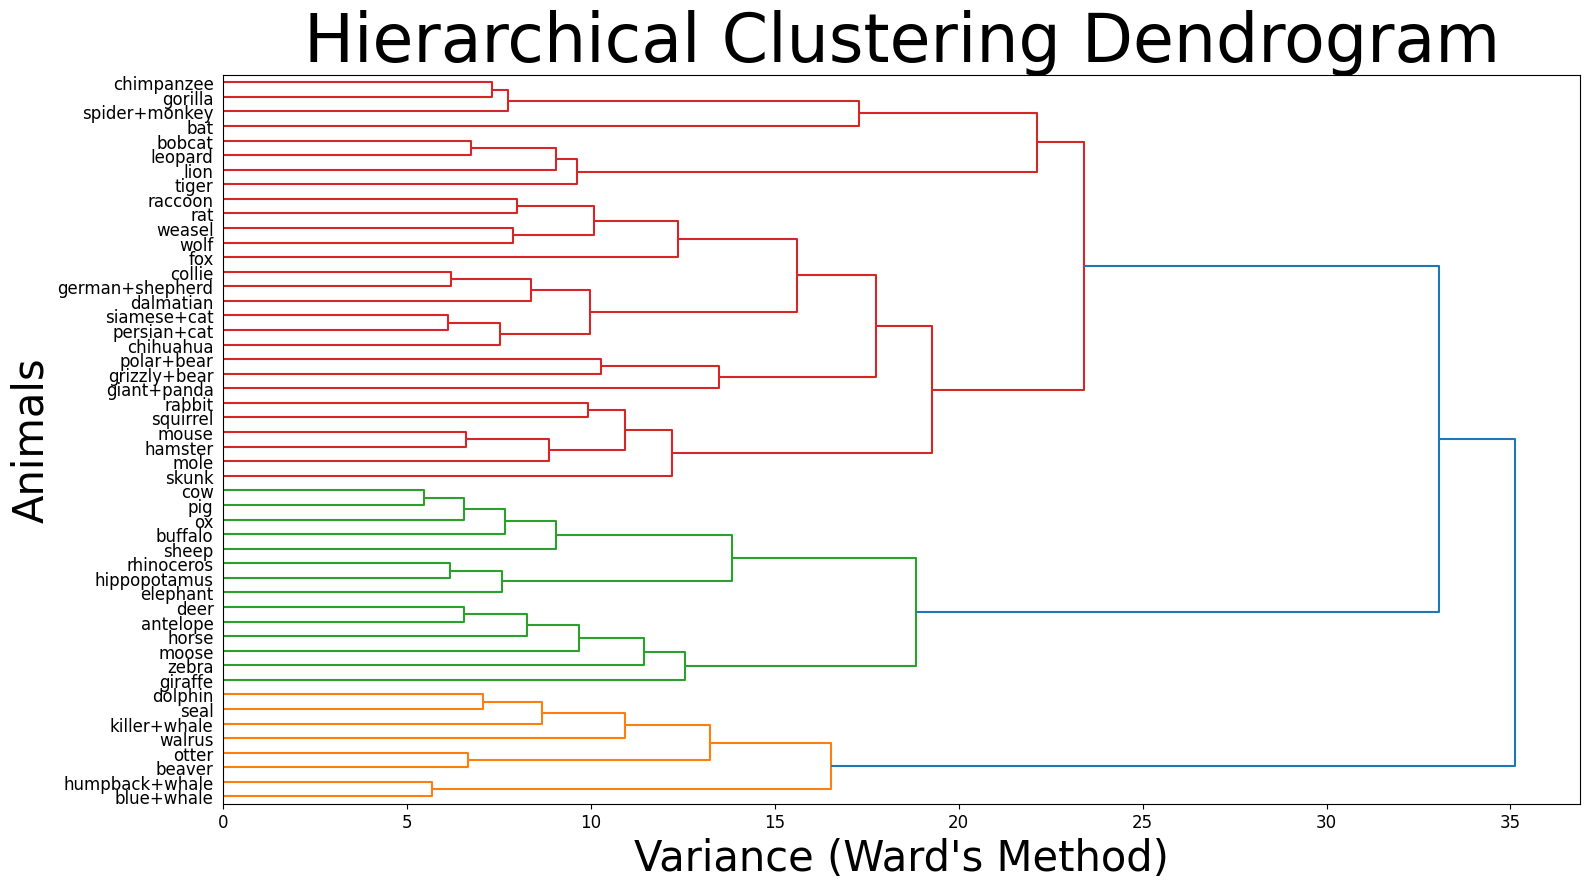

In [17]:
# Creating a figure and axes with specified size and white background
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), facecolor='white')

# Generate the linkage matrix using 'ward' method
cluster_link = linkage(samples_features, method='ward')

# Create a dendrogram and set its orientation to right
dendrogram(cluster_link, orientation="right", labels=classes, ax=ax)

# Hierarchical Clustering Dendrogram
ax.set_title('Hierarchical Clustering Dendrogram', fontsize = 48)
ax.tick_params(labelsize = 12)
ax.set_ylabel('Animals', fontsize = 30)
ax.set_xlabel('Variance (Ward\'s Method)', fontsize = 30)

# Adjust layout for better fit
fig.tight_layout()
#fig.savefig('HierarchicalClusteringDendrogram.png', dpi = 950)